![](https://cdn.shopify.com/s/files/1/0528/8266/9745/files/aa9ba33a428bcfb93a45b4a44e5019d3.jpg?v=1676085807)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.names
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/Index
/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data
/kaggle/input/playground-series-s4e4/sample_submission.csv
/kaggle/input/playground-series-s4e4/train.csv
/kaggle/input/playground-series-s4e4/test.csv


**Your Goal**: The goal of this competition is to predict the age of abalone from various physical measurements.

Predicting the age of abalone from physical measurements.  The age of
abalone is determined by cutting the shell through the cone, staining it,
and counting the number of rings through a microscope -- a boring and
time-consuming task.  Other measurements, which are easier to obtain, are
used to predict the age.  Further information, such as weather patterns
 and location (hence food availability) may be required to solve the problem.

From the original data examples with missing values were removed (the
majority having the predicted value missing), and the ranges of the
continuous values have been scaled for use with an ANN (by dividing by 200).

![](https://www.kaggle.com/competitions/72489/images/header)

# <span style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 50px;">Table of Contents</span>

- [Import libraries](#1)
- [Open data files](#2)
- [Show first 5 lines of train data](#3)
- [Compare original train and competition train](#3.1)
- [Concatenate original train with competition train](#3.2)
- [Shapes of train and test data](#4)
- [Display descriptive statistics of train data](#5)
- [Check the number of gaps for each feature](#6)
- [Figure out how much duplicates in data](#7.1)
- [Remove duplicates from data](#7.2)
- [One-hot encoding](#7.3)
- [More plots](#7.4)
- [Display histograms of distribution](#8)
- [Let's count target of train data](#9)
- [Transform the data with log1p](#10)
- [Feature importance](#10.2)
- [Build a heat map of correlations](#11)
- [Define base models with tuned hyperparameters](#12)
- [Defining the meta-model with tuned hyperparameters](#13)
- [Creating and fitting the stacking model](#14)
- [Predict validation set and calculate accuracy score](#15)
- [Predict the test data](#16)
- [Build DataFrame and make submission](#17)
- [Save the model into pickle file](#18)

<a id='1'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🌊 Import libraries</p>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import pickle
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

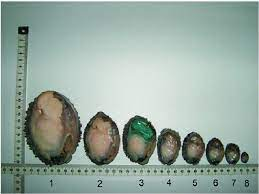

<a id='2'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐚 Open data files</p>

In [3]:
original_train = pd.read_csv('/kaggle/input/ps-4-e-2-abalone-dataset-from-uci/abalone.data')

train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')

<a id='3'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">⛵ Show first 5 lines of train data</p>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [5]:
test.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


### Target feature is 'Rings'

<a id='3.1'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍤 Compare original train and competition train</p>

In [6]:
print(original_train.shape)
original_train.columns.tolist()

(4176, 9)


['M', '0.455', '0.365', '0.095', '0.514', '0.2245', '0.101', '0.15', '15']

### In original data there is no columns in file .data

In [7]:
print(train.shape)
train.columns.tolist()

(90615, 10)


['id',
 'Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

<a id='4'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐟 Shapes of train and test data</p>

In [8]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (90615, 10)
Test data: (60411, 9)

Train data consists of 60.0% of all observations
Test data consists of 40.0% of all observations


![](https://www.altnaturals.com/cdn/shop/products/All-AbaloneSizes-Small_1500x411.jpg?v=1637679377)

<a id='5'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐠 Display descriptive statistics of train data</p>

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,90615.0,45307.000000,26158.441658,0.0000,22653.5000,45307.0000,67960.5000,90614.0000
Length,90615.0,0.517098,0.118217,0.0750,0.4450,0.5450,0.6000,0.8150
Diameter,90615.0,0.401679,0.098026,0.0550,0.3450,0.4250,0.4700,0.6500
Height,90615.0,0.135464,0.038008,0.0000,0.1100,0.1400,0.1600,1.1300
Whole weight,90615.0,0.789035,0.457671,0.0020,0.4190,0.7995,1.0675,2.8255
Whole weight.1,90615.0,0.340778,0.204428,0.0010,0.1775,0.3300,0.4630,1.4880
Whole weight.2,90615.0,0.169422,0.100909,0.0005,0.0865,0.1660,0.2325,0.7600
Shell weight,90615.0,0.225898,0.130203,0.0015,0.1200,0.2250,0.3050,1.0050
Rings,90615.0,9.696794,3.176221,1.0000,8.0000,9.0000,11.0000,29.0000


<a id='6'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐡 Check the number of gaps for each feature</p>

In [10]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64



TEST data

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
dtype: int64


![](https://www.asnailsodyssey.com/views/images/119/Geiger&Owen2019.jpg)

<a id='7'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦈 Data types of training set</p>

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


<a id="7.2"></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦭 Remove duplicates from train data</p>

In [12]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
duplicates = train[train.duplicated()]
len(duplicates)

0

<a id="7.3"></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍢 One-hot encoding

In [13]:
X = pd.get_dummies(train, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

<a id='8'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦞 Display histograms of distribution</p>

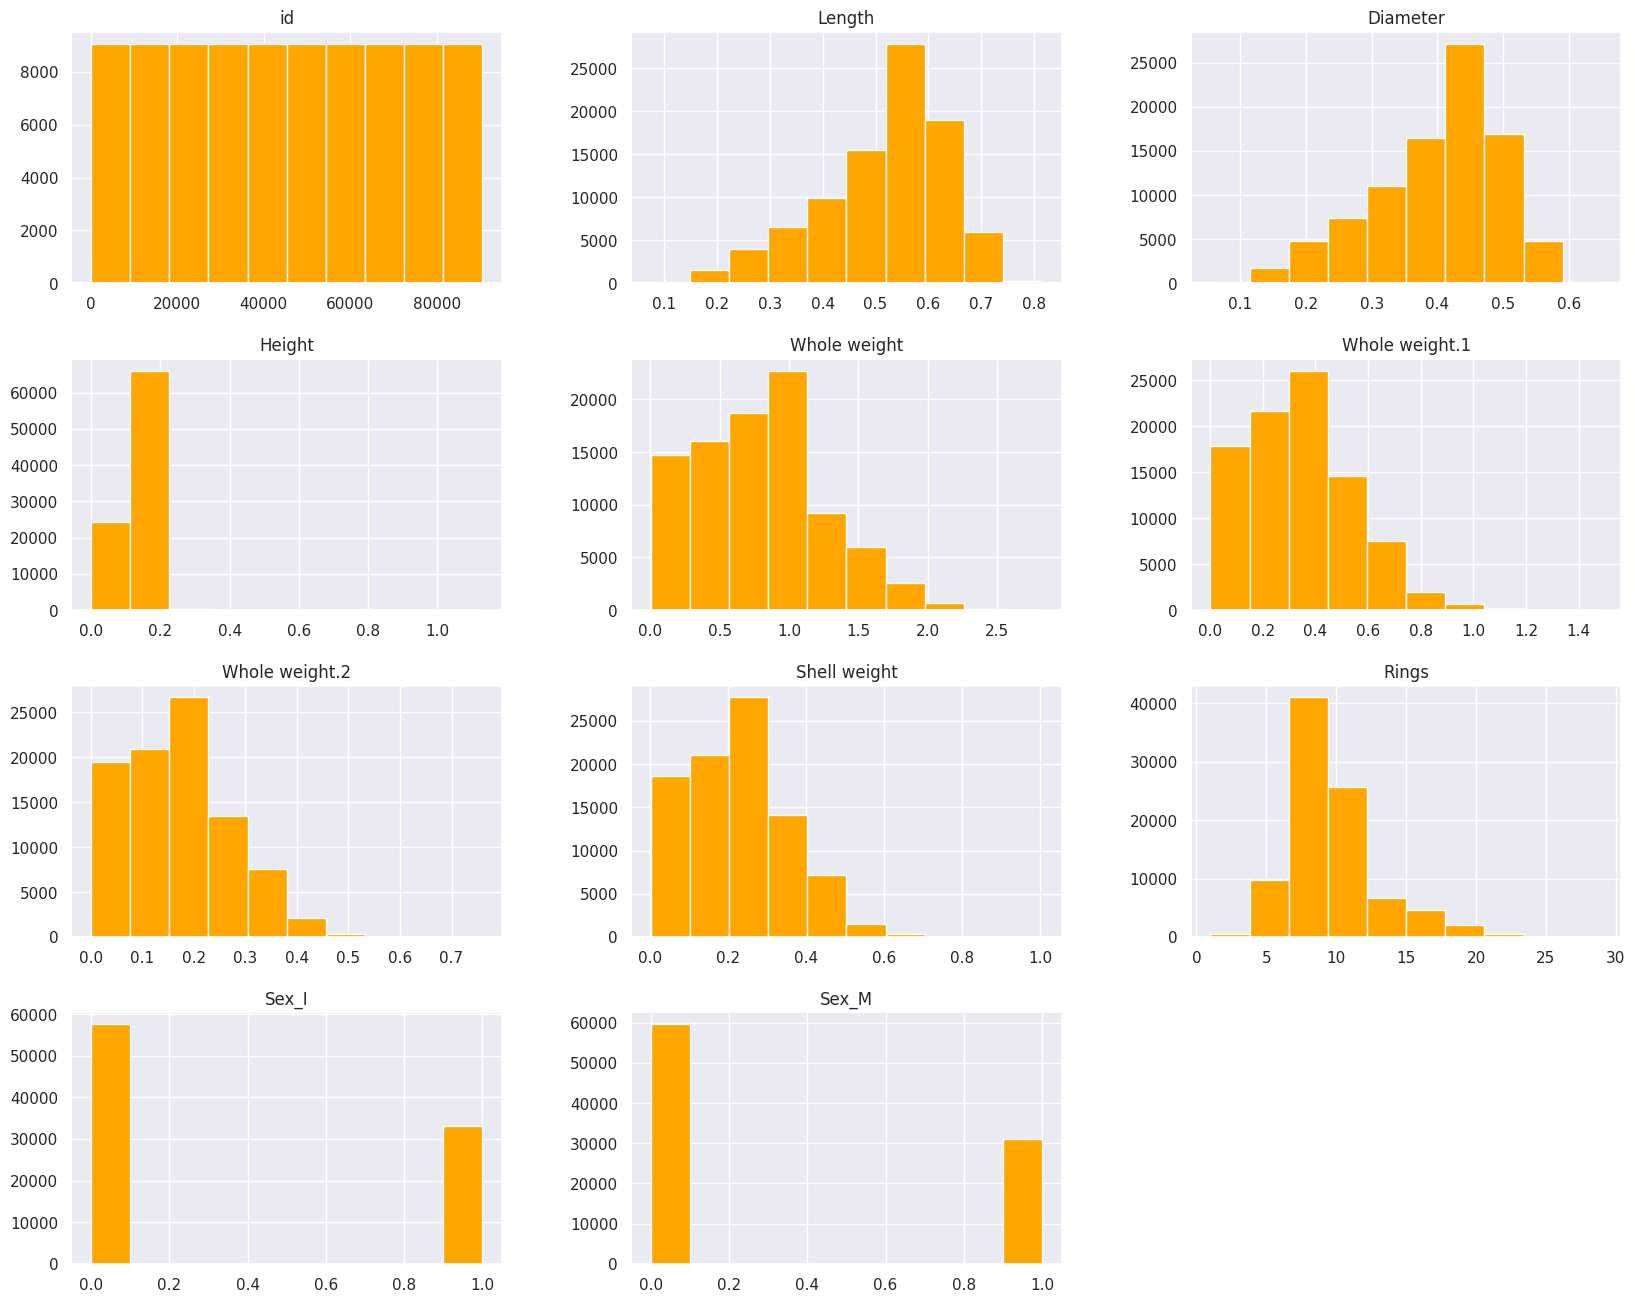

In [14]:
sns.set(rc={'figure.figsize': (20, 16)})
X.hist(color='orange');

<a id='9'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦐 Let's count target of train data</p>

In [15]:
print(f'{train.Rings.value_counts()}\n\n')
print(train.Rings.value_counts() / train.shape[0])

Rings
9     17465
8     14499
10    12464
7      9008
11     8407
6      5411
12     4719
13     4074
5      2862
14     2507
15     2072
16     1439
4      1402
17     1175
18      848
19      639
20      507
3       386
21      255
23      180
22      108
27       41
2        29
24       29
1        25
29       24
25       22
26       18
Name: count, dtype: int64


Rings
9     0.192739
8     0.160007
10    0.137549
7     0.099410
11    0.092777
6     0.059714
12    0.052077
13    0.044959
5     0.031584
14    0.027667
15    0.022866
16    0.015880
4     0.015472
17    0.012967
18    0.009358
19    0.007052
20    0.005595
3     0.004260
21    0.002814
23    0.001986
22    0.001192
27    0.000452
2     0.000320
24    0.000320
1     0.000276
29    0.000265
25    0.000243
26    0.000199
Name: count, dtype: float64


<a id='10'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🦑 Transorm the data with MinMax</p>

In [16]:
# Split the train data into X and y
X = X.drop(['Rings'], axis=1)
y = train.Rings

# for column in X.columns.tolist():
#     X[column] = X[column].apply(lambda x: (x - X[column].min()) / (X[column].max() - X[column].min()))

# # Transform test data
# for column in test.columns.tolist():
#     test[column] = test[column].apply(lambda x: (x - test[column].min()) / (test[column].max() - test[column].min()))
    
# X.hist(color='LightSeaGreen');

![](https://d3h1lg3ksw6i6b.cloudfront.net/media/image/2020/09/24/a40d8dea2d924e0aa7cdb644beffe934_abalone+dish.jpg)

<a id='10.2'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">💦 Feature importance</p>

CPU times: user 1min 1s, sys: 474 ms, total: 1min 1s
Wall time: 1min 1s


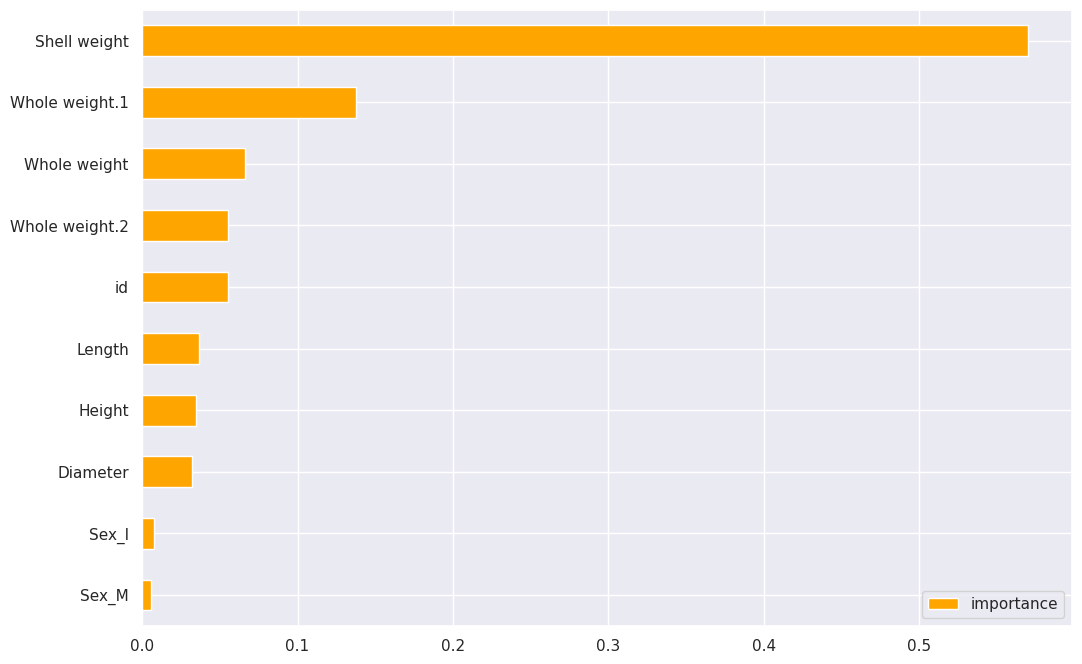

In [17]:
%%time
# I figured out best hyperparameters previously
best_forest = RandomForestRegressor(
    random_state=27,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='orange');

<a id='11'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🌊 Build a heat map of correlations</p>

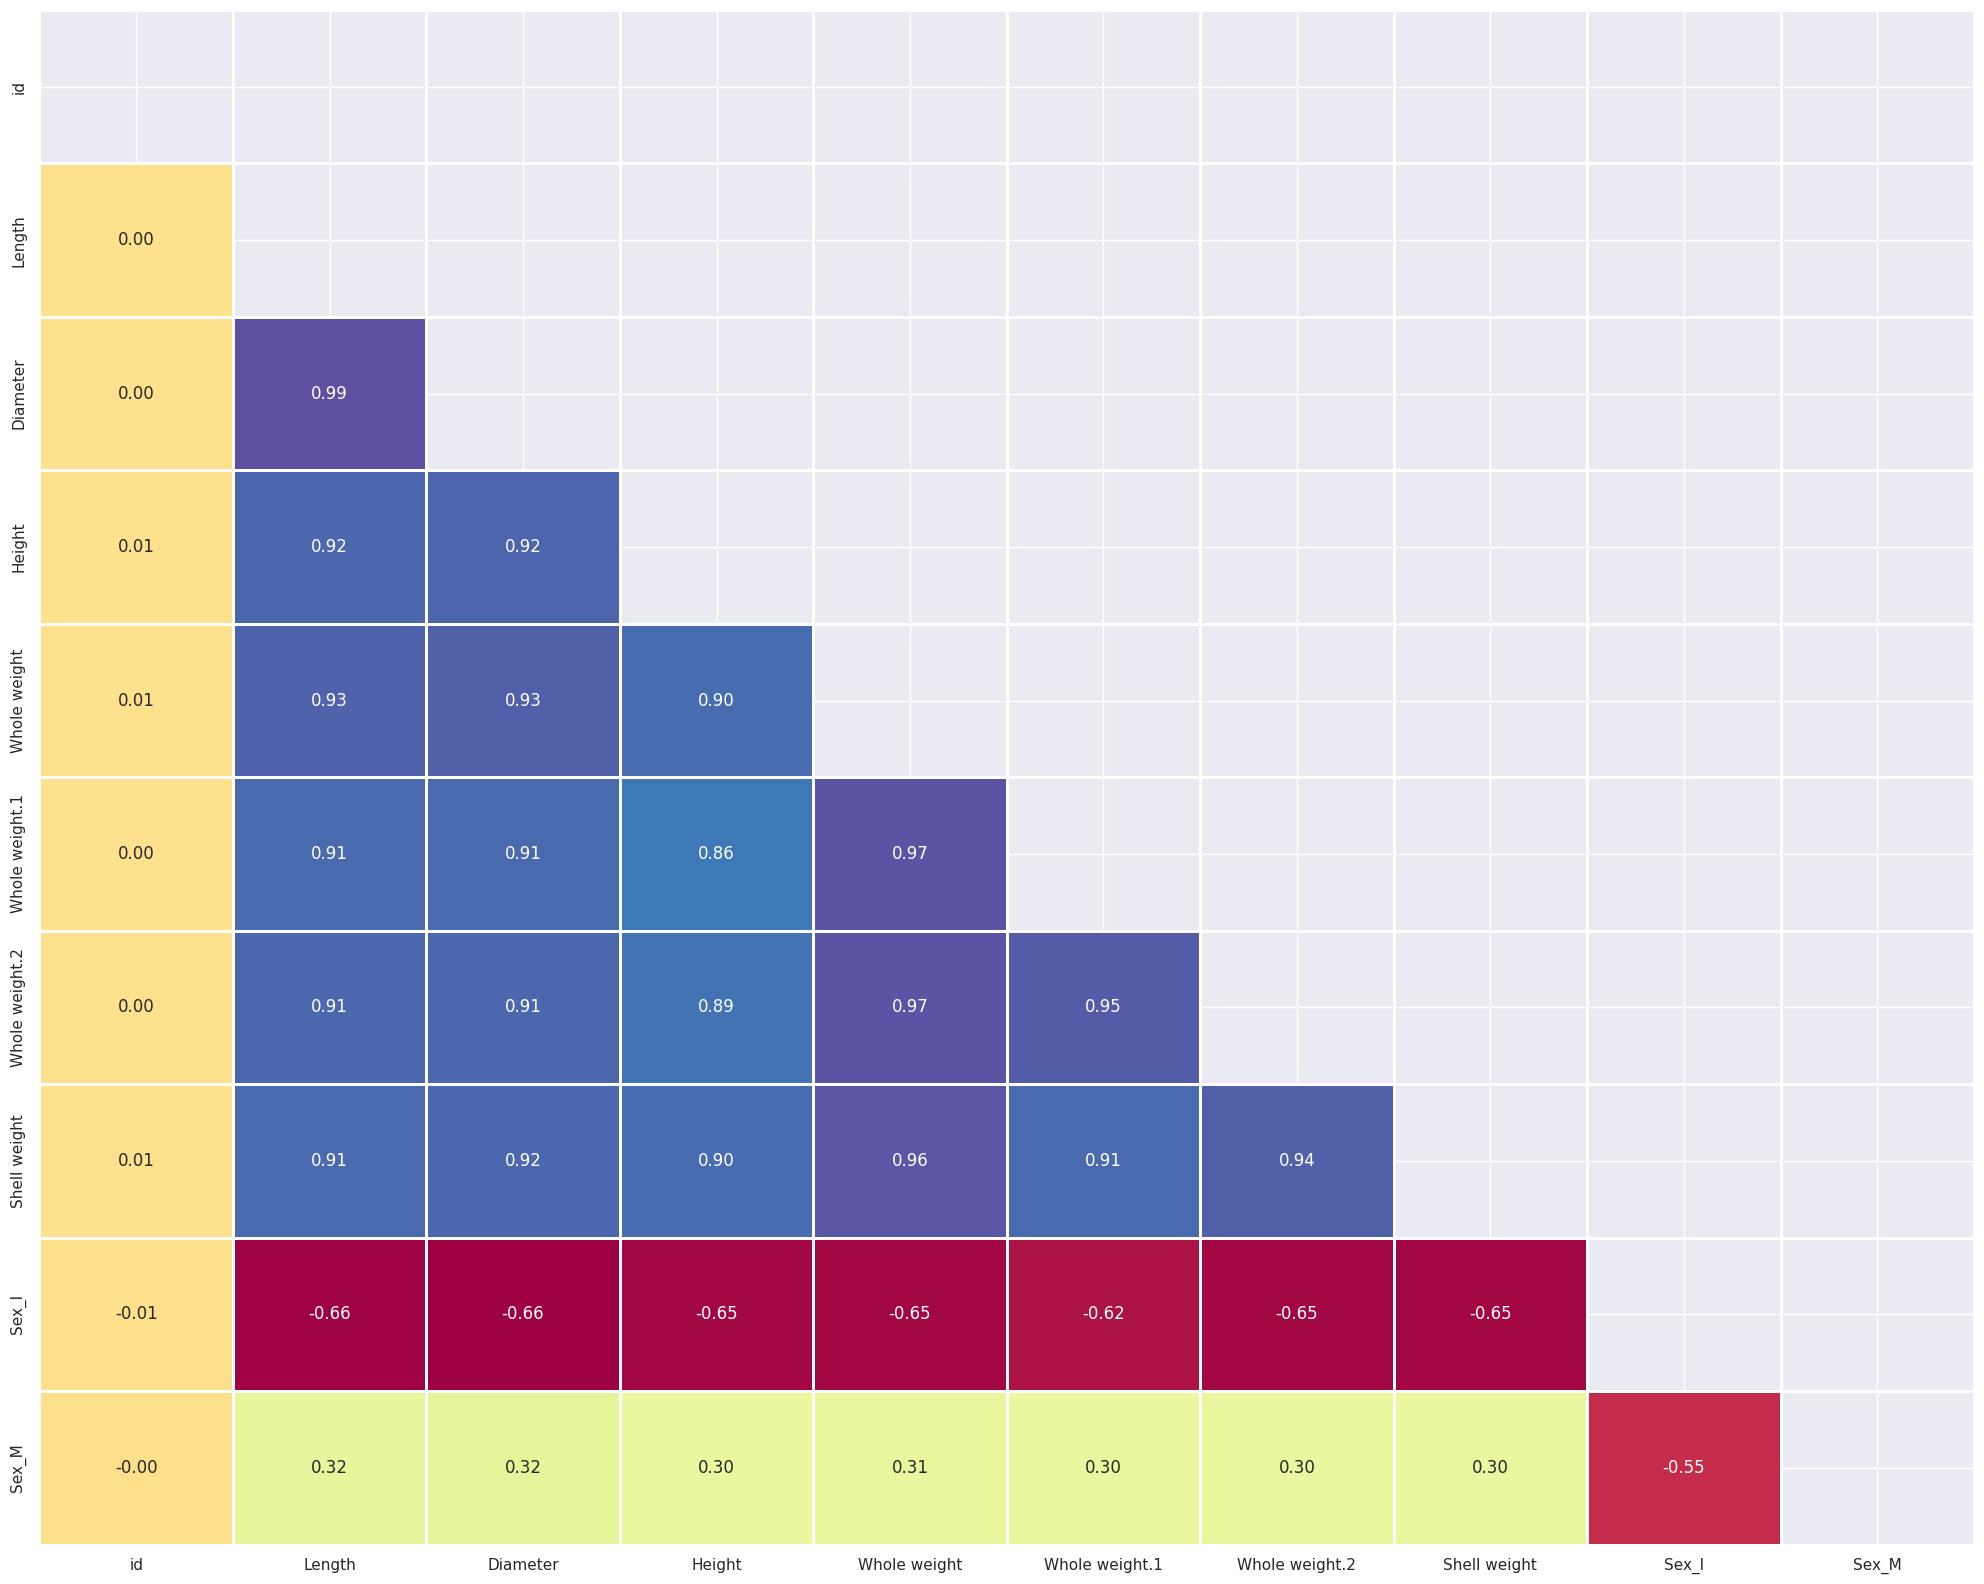

In [18]:
# Training dataset
numeric_columns_train = X.select_dtypes(include=np.number)
corr_train = numeric_columns_train.corr(method='pearson')
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(corr_train, annot=True, fmt='.2f', mask=mask_train, cmap='Spectral', cbar=None, linewidth=2)
plt.tight_layout()
plt.show()

<a id='12'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐚 Define base models</p>

In [19]:
# Split data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

![](https://www.foodrepublic.com/img/gallery/what-exactly-is-abalone-and-how-do-you-eat-it/l-intro-1695291935.jpg)

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px;">Random Forest with Optuna</p>

In [20]:
# %%time
# def objective(trial):
#     model = RandomForestRegressor(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
# #         criterion=trial.suggest_categorical("criterion", ['poisson', 'absolute_error', 'friedman_mse', 'squared_error']),
#         min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 100),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         min_samples_split=trial.suggest_int("min_samples_split", 2, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=5)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

"""
Number of finished trials:  5
Best trial:
  Value:  0.15237508927103727
  Params: 
    n_estimators: 445
    min_samples_leaf: 98
    max_depth: 90
    min_samples_split: 22

CPU times: user 11min 43s, sys: 171 ms, total: 11min 44s
Wall time: 11min 44s
"""

'\nNumber of finished trials:  5\nBest trial:\n  Value:  0.15237508927103727\n  Params: \n    n_estimators: 445\n    min_samples_leaf: 98\n    max_depth: 90\n    min_samples_split: 22\n\nCPU times: user 11min 43s, sys: 171 ms, total: 11min 44s\nWall time: 11min 44s\n'

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">XGBoost with Optuna</p>

In [21]:
# %%time
# def objective(trial):
#     model = XGBRegressor(
#         max_depth=trial.suggest_int('max_depth', 1, 100),
#         learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         n_estimators=trial.suggest_int('n_estimators', 50, 1000),
#         min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
#         gamma=trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         subsample=trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         colsample_bytree=trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         reg_alpha=trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         reg_lambda=trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         use_label_encoder=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">CatBoost with Optuna</p>

In [22]:
# %%time
# def objective(trial):
#     model = CatBoostRegressor(
#         iterations=trial.suggest_int("iterations", 100, 1000),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         colsample_bylevel=trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         min_data_in_leaf=trial.suggest_int("min_data_in_leaf", 1, 100),
#         depth=trial.suggest_int("depth", 7, 10),
#         l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         verbose=False,
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=1)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

## <p style="background-image: url(https://www.kaggle.com/competitions/72489/images/header); color: white; font-size: 30px; padding: 5px 5px 5px 5px">LightGBM with Optuna</p>

In [23]:
# %%time
# def objective(trial):
#     model = LGBMClassifier(
#         n_estimators=trial.suggest_int("n_estimators", 100, 1000),
#         max_depth=trial.suggest_int("max_depth", 1, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         verbosity=-1,
#         boosting_type=trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
#         num_leaves=trial.suggest_int('num_leaves', 2, 256),
#         min_child_samples=trial.suggest_int('min_child_samples', 5, 100),
#         random_state=27
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return np.sqrt(mean_squared_log_error(y_test, y_pred))


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="lgbm", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=5)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
# print()

In [24]:
base_models = [
    ('XGBoost', XGBRegressor(
        random_state=27
    )),
    ('LightGBM', LGBMRegressor(
        random_state=27
    )),
    ('Catboost', CatBoostRegressor(
    random_state=27
    )),
]

![](https://www.frdc.com.au/sites/default/files/fish-magazine/images/fish-vol-26-2/P26_fi_abalone_diving_Yazbeck-Pic-(1).jpg?la=en&hash=2A20AECD5AF45A98BA91D7B78B402ABB4781D789)

<a id='13'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">⛵ Defining the meta-model</p>

In [25]:
meta_model = CatBoostRegressor(
    random_state=27
)

<a id='14'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍤 Creating and fitting the stacking model

In [26]:
%%time
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 10
[LightGBM] [Info] Start training from score 9.696794
Learning rate set to 0.083448
0:	learn: 3.0402100	total: 73ms	remaining: 1m 12s
1:	learn: 2.9198970	total: 84.3ms	remaining: 42.1s
2:	learn: 2.8121215	total: 94.7ms	remaining: 31.5s
3:	learn: 2.7196660	total: 105ms	remaining: 26.1s
4:	learn: 2.6389274	total: 115ms	remaining: 22.9s
5:	learn: 2.5618451	total: 126ms	remaining: 20.9s
6:	learn: 2.4958153	total: 136ms	remaining: 19.3s
7:	learn: 2.4391457	total: 145ms	remaining: 18s
8:	learn: 2.3870465	total: 157ms	remaining: 17.3s
9:	learn: 2.3397345	total: 167ms	r

StackingRegressor(estimators=[('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learnin...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=27, ...)),
                              ('LightGBM', LGBMRegressor(random_state=27)),
                              ('Catboost',
                               <catboost.core.CatBoostRegressor object at 0x7b0d788c79d0>)],
                  final_estimator=<catboost.core.CatBoostRegressor object at 0x7b0d788c7d30>)

<a id='15'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐟 Predict the validation set and calculate Root Mean Squared Logarithmic Error (RMSLE) score</p>

In [27]:
y_pred_val = stacking_model.predict(X_val)

rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
print(f"Validation Root mean squared logarithmic error regression loss: {rmsle_val:.8f}")

Validation Root mean squared logarithmic error regression loss: 0.14305257


<a id='16'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐠 Predict on the test data</p>

In [28]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([ 9.62847707,  9.41969758, 10.1034648 , 10.42932149,  7.65410104,
        9.50892619, 11.58752193,  6.3167144 ,  7.94408325, 10.74958307])

![](https://en.australia51.com/Attach/Download/EA3D1916-8F57-1147-653F-329276FBB95A/0656DE71-5A1F-235F-E504-F21533E82969.jpg)

<a id='17'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🐡 Build DataFrame and make first submission</p>

In [29]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Rings': y_pred_test
})

submission.to_csv('Kapturov_S4E4_submission.csv', index=False)
submission.head(10)

,id,Rings
0,90615,9.628477
1,90616,9.419698
2,90617,10.103465
3,90618,10.429321
4,90619,7.654101
5,90620,9.508926
6,90621,11.587522
7,90622,6.316714
8,90623,7.944083
9,90624,10.749583


<a id='17'></a>
# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">🍥 Save the model into pickle file</p>

In [30]:
import pickle

pickle.dump(stacking_model, open("Kapturov_stacking_model.pkl", "wb"))

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Abalone_at_California_Academy_of_Sciences.JPG/1200px-Abalone_at_California_Academy_of_Sciences.JPG)

# <p style="color: #3EB489; border-bottom: 6px solid  #20603D; background-color: #fadb8c;">😀 Hope You are feeling great!